# Histogram of Oriented Gradients; Color Histograms


## HOG feature extractor

One way to extract more useful features from the raw data is the HOG method. The HOG algorithm finds the edges of the image by calculating gradients and bins these gradient values inside blocks of pixels. Traffic signs contain a lot of edges, e.g. the edges of the traffic sign itself, the arrows drawn on the traffic sign, etc. It is suspected that these HOG features will form a better feature set. Note however that HOG doesn't take into account the colors of the image. A next step to improve the model can be to extract color features from the images and combine them with the HOG features.

## Color Histograms



# 1. Preprocessing 

## 1.1 Loading the data

In [67]:
# Imports
import os
import random
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from data.util import *

In [68]:
# load training and testing data into memory
root_path = "data"
X_train, s_train, y_train_str, p_train, i_train = TrainDataLoader(root_path).load()
X_test = TestDataLoader(root_path).load()
# X_train: all features (pixels x 3) of all training samples (4146)
# s_train: superclasses of all samples (4146); note ordered
# y_train: classes of all samples (4146); note ordered
# p_train: pole IDs of all samples (4146)
# i_train: indices of all samples (4146); note duplicates
# X_test: all features (pixels x 3) of all testing samples (4293)

# Make sure that you properly encode the CLASSES such that 
# the order in your submission files is correct!
label_enc = LabelEncoder()
label_enc.fit(CLASSES)
y_train = label_enc.transform(y_train_str) # numerical labels

# Randomizer
numpy_seed = 0
python_seed = 0
np.random.seed(numpy_seed)
random.seed(python_seed)

In [69]:
# display some numbers
number_of_train_samples = len(X_train)
number_of_classes = len(np.unique(y_train))
number_of_test_samples = len(X_test)
print('number of training samples:', number_of_train_samples)
print('number of testing samples:', number_of_test_samples)
print('number of labels:', number_of_classes)

number of training samples: 4146
number of testing samples: 4293
number of labels: 81


## 1.2 Class distribution

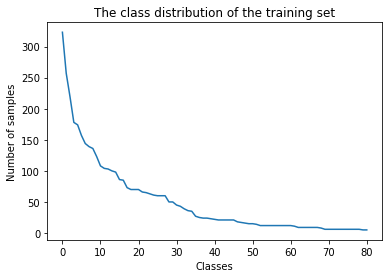

In [72]:
import matplotlib.pyplot as plt
# Create a plot showing the class distribution in the training set
fig_distr, ax_distr = plt.subplots()
ax_distr.set_title("The class distribution of the training set")
ax_distr.set_xlabel("Classes")
ax_distr.set_ylabel("Number of samples")

count = countOcc(y_train)
plt.plot([i for i in range(len(count))], count);
fig_distr.savefig(os.path.join('visualization','class_distribution.png'))

## 1.3 Improve contrast (CLAHE)

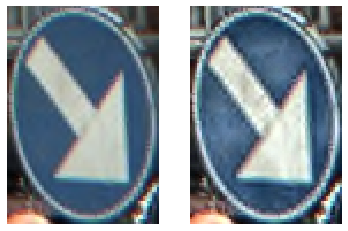

In [73]:
# enhance contrast on all images
X_train_contr = [apply_contrast(image) for image in X_train]
X_test_contr = [apply_contrast(image) for image in X_test]

# Show effect of improving contrast
image_index = 99
image_ori = Image.fromarray(X_train[image_index])
image_con = Image.fromarray(X_train_contr[image_index])

# create figure and show images
fig_con, ax_con = plt.subplots(1,2)
ax_con[0].imshow(image_ori)
ax_con[1].imshow(image_con)
ax_con[0].set_axis_off()
ax_con[1].set_axis_off()

## 1.4 Resize all images to a fixed resolution (with padding)

### 1.4.1. Resize to fixed width or height (depending on aspect ratio)

### 1.4.2. Construct a border in the other direction to make it square

(4146, 64, 64, 3)


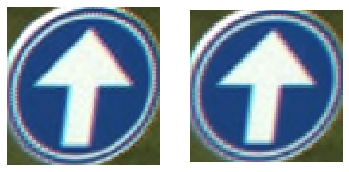

In [75]:
# Reshape all images
X_train_resized = np.array([reshape_(x, s=64) for x in X_train])
X_test_resized = np.array([reshape_(x, s=64) for x in X_test])
print(X_train_resized.shape)


# Show effect of resizing
image_index = 17
image_ori = Image.fromarray(X_train[image_index])
image_res = Image.fromarray(X_train_resized[image_index])
# create figure and show images
fig_res, ax_res = plt.subplots(1,2)
ax_res[0].imshow(image_ori)
ax_res[1].imshow(image_res)
ax_res[0].set_axis_off()
ax_res[1].set_axis_off()

# 2. Feature Extraction

## 2.1. Color Histograms

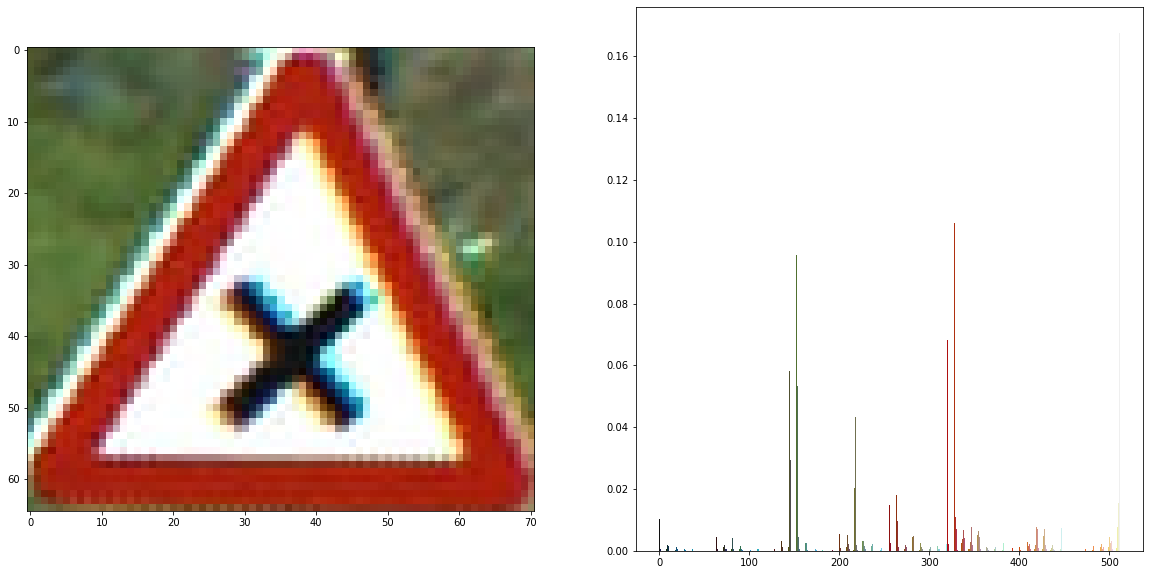

In [76]:
# Note: this cell takes a long time to run
X_train_hist = hist_3d_(np.array(X_train),nbin=8)
X_test_hist = hist_3d_(np.array(X_test),nbin=8)

# Plots the color histogram of an image
nbins=8
colors=[]
for r in np.arange(0.5,nbins+0.5):
    for g in np.arange(0.5,nbins+0.5):
        for b in np.arange(0.5,nbins+0.5):
            colors.append((r/nbins,g/nbins,b/nbins))

image_plot(X_train_hist[:,n],X_train[n],colors)

plt.show()

## 2.2 HOG features

In [78]:
# set parameters for HOG descriptor
print('winSize:', (64,64))
print('blockSize:', (32,32))
print('blockStride:', (16,16))
print('cellSize:', (8,8))
winSize = (64,64)
blockSize = (32,32)
blockStride = (16,16)
cellSize = (8,8)
nbins = 9

derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
signedGradients = True

# create HOG descriptor class object
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

# empty numpy array for HOG features
X_train_hog = np.zeros((number_of_train_samples, hog.getDescriptorSize()))
X_test_hog = np.zeros((number_of_test_samples, hog.getDescriptorSize()))

# iterate over all training images
for idx, sample in enumerate(X_train_resized):
    # turn image raw pixel values into HOG features
    hog_features = hog.compute(sample) # look at other parameters
    X_train_hog[idx] = hog_features[:,0]

# iterate over all testing images
for idx, sample in enumerate(X_test_resized):
    # turn image raw pixel values into HOG features
    hog_features = hog.compute(sample) # look at other parameters
    X_test_hog[idx] = hog_features[:,0]

print(X_train_hog.shape)
print(X_test_hog.shape)
number_of_hog_features = X_train_hog.shape[1]
print('number of hog features:', number_of_hog_features)

winSize: (64, 64)
blockSize: (32, 32)
blockStride: (16, 16)
cellSize: (8, 8)
(4146, 1296)
(4293, 1296)
number of hog features: 1296


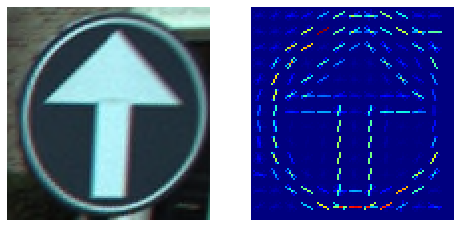

In [118]:
# visualization of HOG features (NOTE: uses skimage HOG)
from skimage.feature import hog

image_index = 7
image_original = X_train[image_index]
fd, image_hog = hog(image_original, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(4, 4), visualize=True, multichannel=True)

fig_hog, ax_hog = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax_hog[0].imshow(image_original)
ax_hog[1].imshow(image_hog)
ax_hog[0].set_axis_off()
ax_hog[1].set_axis_off()

# 3. Feature Visualization

## 3.1 Histogram for 1 feature
A histogram that plots the number of samples with certain HOG values for 1 specific HOG feature.

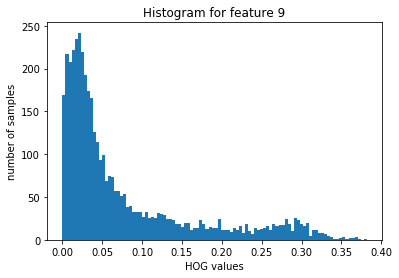

In [81]:
# Visualize the histogram for a specific feature
feature_index = 9
feature = X_train_hog[:,feature_index]
fig_feat, ax_feat = plt.subplots()
ax_feat.set_title("Histogram for feature {}".format(feature_index))
ax_feat.set_xlabel("HOG values")
ax_feat.set_ylabel("number of samples")
plot_histogram(ax_feat, feature, bins=100)

## 3.2 Histogram for 1 sample
A histogram that plots the number of features with certain HOG values for 1 specific sample. There's also a function implemented to plot histograms for multiple samples. This is to visually check for correlations between samples and try to understand what the poleIDs and IDs play as roles in the dataset.
Note that samples with different poleIDs but identical IDs have (visually) identical histograms. This implies a correlation between these samples.

number of training samples: 4146
number of unique training samples: 4112
non-unique sample IDs: ['03696.png', '07331.png', '08988.png', '05098.png', '06044.png', '06812.png', '07925.png', '12300.png', '12921.png', '02901.png', '09836.png', '09896.png', '09808.png', '10473.png', '10831.png', '08474.png', '12857.png', '13130.png', '05968.png', '10644.png', '13260.png', '02304.png', '02852.png', '05108.png', '07215.png', '09837.png', '08599.png', '11529.png', '06891.png', '08723.png', '09956.png']
sample indices for non-unique IDs: [ 85 199]
sample indices for non-unique poleIDs: [   0    1    2 2239 3032]


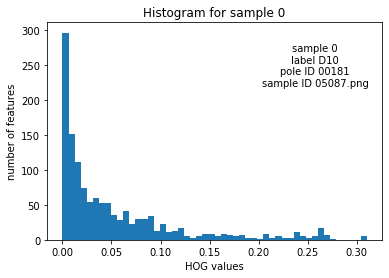

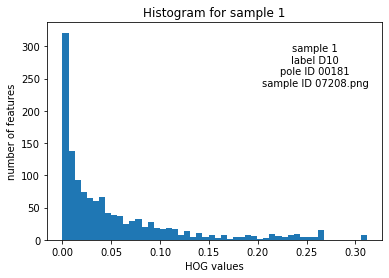

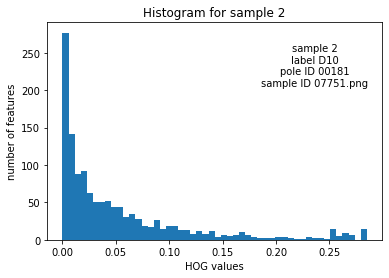

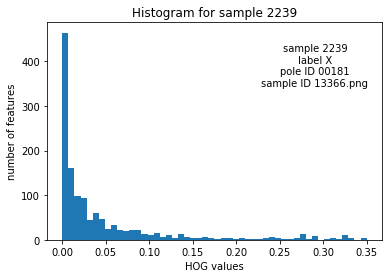

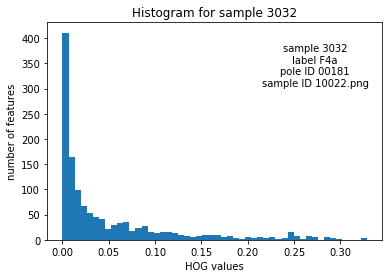

In [120]:
from collections import Counter
# How are the feature histograms for samples with identical ID but different poleID?

# print some numbers
print('number of training samples:', len(i_train))
print('number of unique training samples:', len(np.unique(i_train)))

# find duplicate pole and sample IDs
duplicate_ids = [k for (k,v) in Counter(i_train).items() if v > 1]
duplicate_pole_ids = [k for (k,v) in Counter(p_train).items() if v > 1]
print('non-unique sample IDs:', duplicate_ids)
#print('non-unique sample poleIDs:', duplicate_pole_ids) # too many to print

sample_indices_ids = np.where(np.array(i_train) == duplicate_ids[1])[0]
sample_indices_pole_ids = np.where(np.array(p_train) == duplicate_pole_ids[0])[0]
print('sample indices for non-unique IDs:', sample_indices_ids)
print('sample indices for non-unique poleIDs:', sample_indices_pole_ids)

# Visualize the histogram for a specific sample
def plot_one_sample_hist(sample_index, bins):
    """Plot multiple one sample histograms
    
    :param sample_index: index of sample as in X_train
    :param bins: number of bins used in histogram
    """
    sample = X_train_hog[sample_index,:]
    image = Image.fromarray(X_train[sample_index])
    #image.show() # uncomment to show corresponding images
    fig_samp, ax_samp = plt.subplots()
    ax_samp.set_title("Histogram for sample {}".format(sample_index))
    ax_samp.set_xlabel("HOG values")
    ax_samp.set_ylabel("number of features")
    ax_samp.text(0.8, 0.8, 'sample {}\nlabel {}\npole ID {}\nsample ID {}'.format(
        sample_index, y_train_str[sample_index], p_train[sample_index], i_train[sample_index]), 
                     horizontalalignment='center', verticalalignment='center', 
                         transform=ax_samp.transAxes)
    plot_histogram(ax_samp, sample, bins)
    fig_samp.savefig(os.path.join('visualization', 'samples', f'sample{sample_index}'))

for sample_index in sample_indices_pole_ids:
    plot_one_sample_hist(sample_index, bins=50)

## 3.3. Feature Combination

In [83]:
X_train_hog_hist = np.concatenate((X_train_hog, X_train_hist.T), axis=1)
X_test_hog_hist = np.concatenate((X_test_hog, X_test_hist.T), axis=1)
print(X_train_hog_hist.shape)
print(X_test_hog_hist.shape)

(4146, 1808)
(4293, 1808)


## 3.4. Feature Correlations

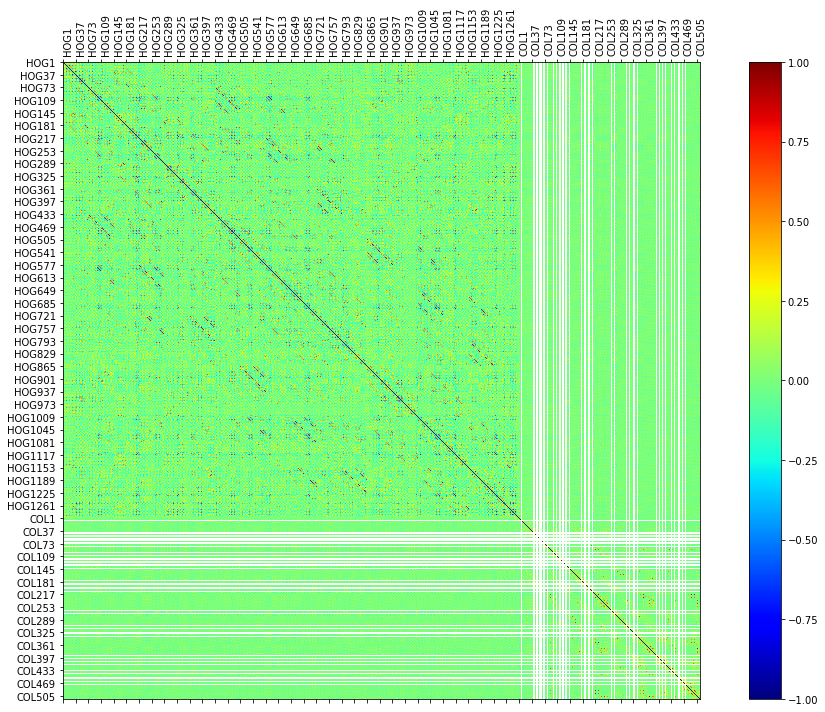

In [87]:
# We can also look at the correlations between feature pairs 
# and between the features and the labels
import pandas as pd
from matplotlib import cm 

# turn numpy X_train into pd dataframe and add column with labels
row_names = [i for i in range(1,number_of_train_samples+1)]
column_names = ['HOG'+ str(i) for i in range(1,number_of_hog_features+1)]
column_names = column_names + ['COL' + str(i) for i in range(1,8**3+1) ]
pd_X_train_hog_hist = pd.DataFrame(data=X_train_hog_hist, 
                                  index=row_names,
                                        columns=column_names)
pd_X_train_hog_hist['class'] = y_train
pd_X_train_hog_hist.head()
plot_correlation_matrix(pd_X_train_hog_hist)

# 4. Pipeline

## 4.1 Simple untuned model with HOG features

In [89]:
pipeline = Pipeline(steps=[('scaler', StandardScaler(with_std=False)),
                ('lr_classifier', LogisticRegression(C=100, class_weight='balanced', 
                    max_iter=1000, multi_class='multinomial', n_jobs=-2))])    
folds = 5
sgkf = stratified_group_k_fold(X_train_hog_hist, y_train, p_train, k=folds)
scores = cross_validate(pipeline, X_train_hog_hist, y_train, groups=p_train,
                            cv=sgkf, scoring=neg_logloss_scorer, return_train_score=True)

show_scores(scores)

Training score -0.005071481536310354 +/- 0.00013862576005596735
Cross-validation score: -0.22327875675116315 +/- 0.07998166933774854


## 4.2 Subset Selection

### 4.2.1. SelectKBest

In [90]:
from sklearn.feature_selection import SelectKBest, chi2

print(X_train_hog_hist.shape)
skb = SelectKBest(chi2, k=100).fit_transform(X_train_hog_hist, y_train)
print(skb.shape)

(4146, 1808)
(4146, 100)


In [91]:
sgkf = stratified_group_k_fold(skb, y_train, p_train, k=folds)
scores_skb = cross_validate(pipeline, skb, y_train, groups=p_train,
                            cv=sgkf, scoring=neg_logloss_scorer, return_train_score=True)

show_scores(scores_skb)

Training score -0.12850422836414016 +/- 0.005222650552087947
Cross-validation score: -0.5447782604487268 +/- 0.1140977018926761


### 4.2.3. Implementing PCA

In [92]:
from sklearn.decomposition import PCA

# Pipeline
# n_components is the PCA hyperparameter = amount of components kept
n_comps = 30
estimator = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=n_comps)),
    ('lr_classifier', LogisticRegression(C=10, max_iter=1000, 
        n_jobs=-2, multi_class='auto', class_weight=None))
    ])

folds = 5
sgkf = stratified_group_k_fold(X_train_hog_hist, y_train, p_train, k=folds)
scores = cross_validate(estimator, X_train_hog_hist, y_train, groups=p_train,
                            cv=sgkf, scoring=neg_logloss_scorer, return_train_score=True)

show_scores(scores)
estimator.fit(X_train_hog_hist, y_train)

Training score -0.027011622960012544 +/- 0.0021440139406306382
Cross-validation score: -0.37549114823872304 +/- 0.11641960815481243


Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=30)),
                ('lr_classifier',
                 LogisticRegression(C=10, max_iter=1000, n_jobs=-2))])

## 4.3 Tuned model
Tuning of the hyperparameters happens here. Before we can start doing this, we should first evaluate the model using the train-CV and CV-test gaps as well as the learning curves. 

In [93]:
from sklearn.model_selection import GridSearchCV

# robust scaler pipeline
#pipeline = Pipeline(
#            [('scaler', RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))), 
#                         ('lr_classifier', LogisticRegression(C=1.0, tol=1e-4, class_weight='balanced', fit_intercept=True,
#                                multi_class='multinomial', solver='lbfgs',max_iter=100, n_jobs=-2))
#            ])

# standard scaler pipeline
pipeline = Pipeline(
            [('scaler', StandardScaler(with_mean=True, with_std=False)), 
                         ('lr_classifier', LogisticRegression(C=1.0, class_weight='balanced', 
                                multi_class='multinomial', solver='lbfgs',max_iter=1000, n_jobs=-2))
            ])

# tuning ranges
Boolean = [True, False]
Weights = ['balanced', None]
C_range = [1.0e-3,1.0e-2,1.0e-1,1.0, 10, 100, 1000]
Class = ['ovr', 'multinomial']
Ranges = [(5.0, 95.0), (10.0, 90.0), (15.0, 85.0), (20.0, 80.0), (25.0, 75.0)]

# parameter grid
#param_grid = {'scaler__with_centering':Boolean, 'scaler__with_scaling':Boolean, 
#                  'scaler__quantile_range':Ranges, 'lr_classifier__class_weight':Weights, 
#                      'lr_classifier__C':C_range} # extended search
param_grid = {'lr_classifier__C':C_range} # short search

# perform grid search
folds = 5
sgkf = stratified_group_k_fold(X_train_hog_hist, y_train, p_train, k=folds)
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=sgkf, 
                           scoring=neg_logloss_scorer, n_jobs=-2, verbose=True, 
                               return_train_score=True)
grid_search.fit(X_train_hog_hist, y_train, groups=p_train)
show_grid_scores(grid_search)

# get best model and calculate score
estimator = get_best_model(grid_search)
sgkf = stratified_group_k_fold(X_train_hog_hist, y_train, p_train, k=folds)
scores = cross_validate(estimator, X_train_hog_hist, y_train, groups=p_train, cv=sgkf, scoring=neg_logloss_scorer, return_train_score=True)
show_scores(scores)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 out of  35 | elapsed:  1.9min finished


Grid scores on training data set:
-4.275 (+/-0.004) for {'lr_classifier__C': 0.001}
-3.389 (+/-0.030) for {'lr_classifier__C': 0.01}
-1.264 (+/-0.088) for {'lr_classifier__C': 0.1}
-0.445 (+/-0.115) for {'lr_classifier__C': 1.0}
-0.259 (+/-0.134) for {'lr_classifier__C': 10}
-0.223 (+/-0.160) for {'lr_classifier__C': 100}
-0.230 (+/-0.191) for {'lr_classifier__C': 1000}
Best parameters set found on development set:  {'lr_classifier__C': 100}

Obtained pipeline:
Pipeline(steps=[('scaler', StandardScaler(with_std=False)),
                ('lr_classifier',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=1000, multi_class='multinomial',
                                    n_jobs=-2))])
Training score -0.005071481536310354 +/- 0.00013862576005596735
Cross-validation score: -0.22327875675116315 +/- 0.07998166933774854


# 5. Model Evaluation

## 5.1. Learning Curve

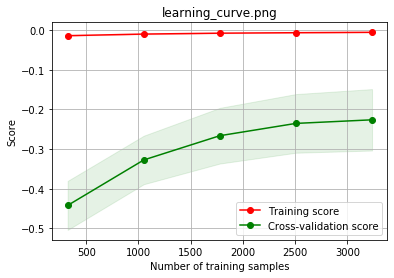

In [94]:
# calculate and plot learning curve
sgkf = stratified_group_k_fold(X_train_hog_hist, y_train, p_train, k=folds)
learn_curv = learning_curve(estimator, X_train_hog_hist, y_train, train_sizes=np.linspace(.1, 1.0, 5),
                                cv=sgkf, groups=p_train, scoring=neg_logloss_scorer, 
                                    n_jobs=3, shuffle=True)
plot_learning_curve(learn_curv, 'learning_curve.png')

## 5.2. Confusion Matrix

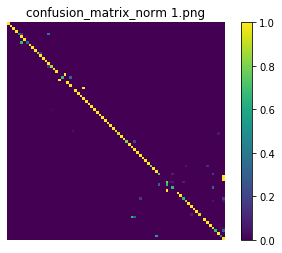

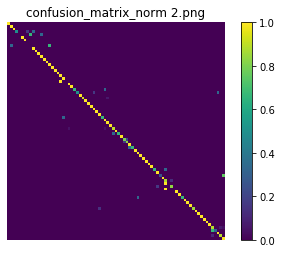

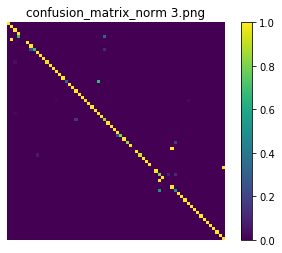

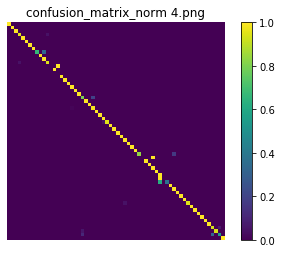

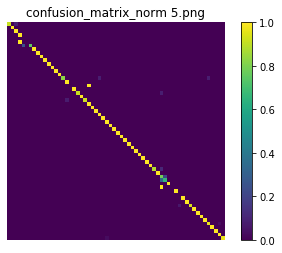

In [96]:
# do a train-test split; stratified and grouped
sgkf_conf = stratified_group_k_fold(X_train_hog_hist, y_train, p_train, k=folds)
n=1
for train_index, test_index in sgkf_conf: # remember that this contains k folds
    train_indices, test_indices = train_index, test_index # only remember the last one
    # train estimator on training data
    estimator.fit(X_train_hog_hist[train_indices], y_train[train_indices])
    # predict class on cross-validation data
    y_pred = estimator.predict(X_train_hog_hist[test_indices])
    y_true = y_train[test_indices]

    conf_matr = confusion_matrix(y_true, y_pred, normalize='true') # normalised
    plot_confusion_matrix(conf_matr, 'confusion_matrix_norm {}.png'.format(n))
    n+=1

# 6. Submission

In [97]:
# train best model using all training data
estimator.fit(X_train_hog_hist, y_train)
# Here is where we create the submission for your estimator
output_probabilities = estimator.predict_proba(X_test_hog_hist)
create_submission(output_probabilities, 'submission.csv')